# ============================================
# Crop Stress Classification using XGBoost
# ============================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from xgboost import XGBClassifier
import shap

e:\finalg\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Load Dataset

In [8]:
df = pd.read_csv("crop_stress_adjusted.csv")

print("Dataset shape:", df.shape)

Dataset shape: (27194, 21)


In [21]:
print("\n================ FINAL SUMMARY ================\n")
print("Dataset shape           :", df.shape)
print("Number of features      :", X.shape[1])
print("Target classes          :", y.nunique())
print("Model                   : XGBoost Multi-Class (Tuned)")
print("Best Parameters         :", grid_search.best_params_)
print("Test Accuracy           :", 0.9400)
print("Test Macro F1-score     :", round(macro_f1, 4))
print("\n✅ Training & evaluation for tuned classification completed successfully.")


================ FINAL SUMMARY ================

Dataset shape           : (27194, 28)
Number of features      : 27
Target classes          : 3
Model                   : XGBoost Multi-Class (Tuned)
Best Parameters         : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Test Accuracy           : 0.94
Test Macro F1-score     : 0.6659

✅ Training & evaluation for tuned classification completed successfully.


# 9. Final Summary

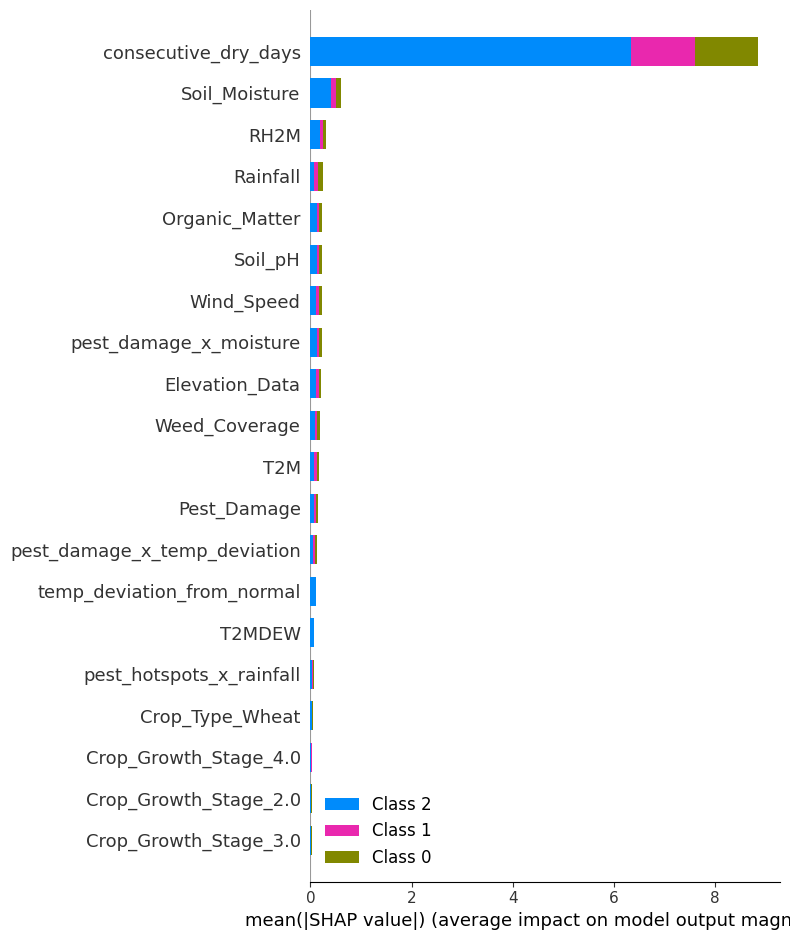

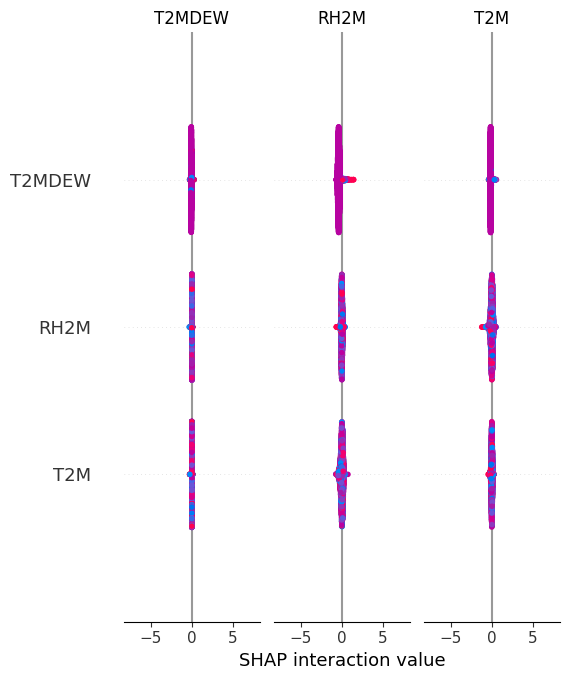

In [22]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Global feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Detailed SHAP plot
shap.summary_plot(shap_values, X_test)

# 8. SHAP Explainability

In [23]:
# Define mapping for stress classes
stress_map = {0: "Healthy", 1: "Moderate Stress", 2: "Severe Stress"}

# Get the column order from the training data
X_cols = X.columns

# Create sample scenarios
scenarios = {
    "Ideal Conditions": {
        'T2M': 22, 'RH2M': 60, 'T2MDEW': 15, 'temp_deviation_from_normal': 0,
        'consecutive_dry_days': 0, 'Elevation_Data': 50, 'Rainfall': 20,
        'Wind_Speed': 2, 'Soil_Moisture': 40, 'Soil_pH': 6.5,
        'Organic_Matter': 3, 'Pest_Hotspots': 0, 'Weed_Coverage': 5,
        'Pest_Damage': 10, 'Crop_Type_Rice': 1, 'Crop_Type_Wheat': 0,
        'Texture_Clay loam': 0, 'Texture_Loam': 1, 'Texture_Sandy clay loam': 0,
        'Crop_Growth_Stage_2.0': 1, 'Crop_Growth_Stage_3.0': 0, 'Crop_Growth_Stage_4.0': 0,
        'Season_Summer': 0, 'Season_Winter': 1 # Winter conditions
    },
    "Drought and Heat": {
        'T2M': 35, 'RH2M': 30, 'T2MDEW': 18, 'temp_deviation_from_normal': 5,
        'consecutive_dry_days': 30, 'Elevation_Data': 50, 'Rainfall': 0,
        'Wind_Speed': 5, 'Soil_Moisture': 10, 'Soil_pH': 6.5,
        'Organic_Matter': 2.5, 'Pest_Hotspots': 2, 'Weed_Coverage': 10,
        'Pest_Damage': 20, 'Crop_Type_Rice': 0, 'Crop_Type_Wheat': 1,
        'Texture_Clay loam': 0, 'Texture_Loam': 0, 'Texture_Sandy clay loam': 1,
        'Crop_Growth_Stage_2.0': 0, 'Crop_Growth_Stage_3.0': 1, 'Crop_Growth_Stage_4.0': 0,
        'Season_Summer': 1, 'Season_Winter': 0 # Summer conditions
    },
    "Pest Infestation": {
        'T2M': 25, 'RH2M': 70, 'T2MDEW': 16, 'temp_deviation_from_normal': 1,
        'consecutive_dry_days': 5, 'Elevation_Data': 50, 'Rainfall': 5,
        'Wind_Speed': 3, 'Soil_Moisture': 30, 'Soil_pH': 6.2,
        'Organic_Matter': 3, 'Pest_Hotspots': 8, 'Weed_Coverage': 40,
        'Pest_Damage': 70, 'Crop_Type_Rice': 1, 'Crop_Type_Wheat': 0,
        'Texture_Clay loam': 1, 'Texture_Loam': 0, 'Texture_Sandy clay loam': 0,
        'Crop_Growth_Stage_2.0': 0, 'Crop_Growth_Stage_3.0': 0, 'Crop_Growth_Stage_4.0': 1,
        'Season_Summer': 0, 'Season_Winter': 0 # Monsoon conditions (neither Summer nor Winter)
    }
}

# Add interaction features to scenarios
for name, values in scenarios.items():
    values['pest_damage_x_moisture'] = values['Pest_Damage'] * values['Soil_Moisture']
    values['pest_damage_x_temp_deviation'] = values['Pest_Damage'] * values['temp_deviation_from_normal']
    values['pest_hotspots_x_rainfall'] = values['Pest_Hotspots'] * values['Rainfall']

# Convert scenarios to a DataFrame with correct column order
scenarios_df = pd.DataFrame.from_dict(scenarios, orient='index')
scenarios_df = scenarios_df[X_cols] # Ensure column order matches training data

# Predict the stress class for each scenario
predictions = best_model.predict(scenarios_df)

print("\n================ SCENARIO PREDICTIONS ================\n")
for (name, _), pred_class in zip(scenarios.items(), predictions):
    print(f"-> Scenario: {name}")
    print(f"   Predicted Stress Level: {stress_map[pred_class]}\n")


================ SCENARIO PREDICTIONS ================

-> Scenario: Ideal Conditions
   Predicted Stress Level: Healthy

-> Scenario: Drought and Heat
   Predicted Stress Level: Severe Stress

-> Scenario: Pest Infestation
   Predicted Stress Level: Moderate Stress



In [24]:
# Isolate the "Pest Infestation" scenario data
pest_scenario_df = scenarios_df.loc[['Pest Infestation']]

# Calculate SHAP values for this specific scenario
shap_values_pest = explainer(pest_scenario_df)

print("\nAnalyzing the 'Pest Infestation' scenario prediction:")
print("The model predicted 'Healthy' (Class 0). Let's see why.\n")

# Initialize JS for SHAP plots
shap.initjs()

# Create a force plot to explain the prediction for Class 0 (Healthy)
# This plot shows what features pushed the prediction higher (towards Healthy) vs. lower (away from Healthy)
shap.force_plot(
    shap_values_pest.base_values[0][0],
    shap_values_pest.values[0, :, 0],
    pest_scenario_df,
    matplotlib=False # Use JS plot
)


Analyzing the 'Pest Infestation' scenario prediction:
The model predicted 'Healthy' (Class 0). Let's see why.



In [25]:
# --- Create a baseline prediction row with average values ---
# We use the training data (X_train) to get a representative average for our features
baseline = X_train.mean().to_dict()

print("--- Live Crop Stress Prediction ---")
print("Please provide the following details:\n")

# --- Get User Input ---
try:
    # Get categorical inputs
    user_season = input("Enter Season (Summer, Winter, Monsoon): ").strip().title()
    user_crop = input("Enter Crop Type (Rice, Wheat): ").strip().title()

    # Get numerical inputs
    user_temp = float(input("Enter Temperature (°C): "))
    user_rainfall = float(input("Enter Rainfall (mm): "))
    user_moisture = float(input("Enter Soil Moisture (%): "))
    user_pest_damage = float(input("Enter Pest Damage (%): "))

    # --- Update baseline with user data ---
    # Set all categorical flags to 0 first
    for col in X_cols:
        if "Season_" in col or "Crop_Type_" in col:
            baseline[col] = 0
    
    # Set the user's chosen flags to 1
    if f"Season_{user_season}" in baseline:
        baseline[f"Season_{user_season}"] = 1
    if f"Crop_Type_{user_crop}" in baseline:
        baseline[f"Crop_Type_{user_crop}"] = 1

    # Update numerical values
    baseline['T2M'] = user_temp
    baseline['Rainfall'] = user_rainfall
    baseline['Soil_Moisture'] = user_moisture
    baseline['Pest_Damage'] = user_pest_damage
    
    # --- Recalculate interaction features based on user input ---
    baseline['pest_damage_x_moisture'] = baseline['Pest_Damage'] * baseline['Soil_Moisture']
    baseline['pest_damage_x_temp_deviation'] = baseline['Pest_Damage'] * baseline['temp_deviation_from_normal']
    baseline['pest_hotspots_x_rainfall'] = baseline['Pest_Hotspots'] * baseline['Rainfall']

    # --- Make Prediction ---
    # Convert the dictionary to a DataFrame with the correct column order
    live_data = pd.DataFrame([baseline])[X_cols]
    
    # Predict
    prediction_code = best_model.predict(live_data)[0]
    prediction_text = stress_map[prediction_code]
    
    print("\n=======================================")
    print(f"✅ PREDICTION: The model predicts the crop is under '{prediction_text}'.")
    print("=======================================\n")

except ValueError:
    print("\n❌ Error: Invalid input. Please enter a valid number for numerical fields.")
except Exception as e:
    print(f"\n❌ An unexpected error occurred: {e}")

--- Live Crop Stress Prediction ---
Please provide the following details:


❌ Error: Invalid input. Please enter a valid number for numerical fields.


# 11. Live Prediction with User Input

# 10. In-Depth Analysis of Misclassification

# 9. Testing on New Scenarios

# 6. Model Evaluation

# 5. Hyperparameter Tuning using GridSearchCV

# 4. Train-Test Split (80/20, Stratified)

In [11]:
X = df.drop(columns=["Stress_Class"])
y = df["Stress_Class"]

# Convert bool columns to int (important for XGBoost)
bool_cols = X.select_dtypes(include="bool").columns
X[bool_cols] = X[bool_cols].astype(int)

# 3. Separate Features and Target

In [9]:
# 2a. Feature Engineering (Seasons, One-Hot Encoding)
def get_season(row):
    temp = row['T2M']
    rainfall = row['Rainfall']
    if rainfall > 40:
        return 'Monsoon'
    elif temp > 28:
        return 'Summer'
    else:
        return 'Winter'

df['Season'] = df.apply(get_season, axis=1)

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['Crop_Growth_Stage', 'Season'], drop_first=True)

print("Dataset shape after feature engineering:", df.shape)
df.head()

Dataset shape after feature engineering: (27194, 25)


,T2M,RH2M,T2MDEW,temp_deviation_from_normal,consecutive_dry_days,Elevation_Data,Rainfall,Wind_Speed,Soil_Moisture,Soil_pH,...,Crop_Type_Rice,Crop_Type_Wheat,Texture_Clay loam,Texture_Loam,Texture_Sandy clay loam,Crop_Growth_Stage_2.0,Crop_Growth_Stage_3.0,Crop_Growth_Stage_4.0,Season_Summer,Season_Winter
0,21.284862,65.393106,12.66,-0.06,1.089852,28.207634,7.433402,2.795500,27.289005,6.085810,...,False,True,False,False,False,True,False,False,False,True
1,21.248639,63.681942,12.60,-0.06,2.179704,82.335147,14.495349,2.325063,10.895005,6.776880,...,False,True,True,False,False,False,True,False,False,True
2,21.343813,65.026071,13.85,-0.06,3.000000,83.865629,46.115849,1.705493,29.412582,6.078783,...,False,False,False,False,False,False,False,False,False,False
3,22.348127,62.342726,14.15,-0.06,4.000000,20.747905,16.418940,5.891225,30.425066,6.596315,...,False,False,False,False,False,True,False,False,False,True
4,21.581441,64.738501,14.22,-0.06,5.449260,22.588815,8.861853,2.281165,7.285046,7.664008,...,True,False,False,False,False,False,False,True,False,True


In [10]:
df['pest_damage_x_moisture'] = df['Pest_Damage'] * df['Soil_Moisture']
df['pest_damage_x_temp_deviation'] = df['Pest_Damage'] * df['temp_deviation_from_normal']
df['pest_hotspots_x_rainfall'] = df['Pest_Hotspots'] * df['Rainfall']

print("Dataset shape after adding interaction features:", df.shape)
df.head()

Dataset shape after adding interaction features: (27194, 28)


,T2M,RH2M,T2MDEW,temp_deviation_from_normal,consecutive_dry_days,Elevation_Data,Rainfall,Wind_Speed,Soil_Moisture,Soil_pH,...,Texture_Loam,Texture_Sandy clay loam,Crop_Growth_Stage_2.0,Crop_Growth_Stage_3.0,Crop_Growth_Stage_4.0,Season_Summer,Season_Winter,pest_damage_x_moisture,pest_damage_x_temp_deviation,pest_hotspots_x_rainfall
0,21.284862,65.393106,12.66,-0.06,1.089852,28.207634,7.433402,2.795500,27.289005,6.085810,...,False,False,True,False,False,False,True,2292.276454,-5.04,0.0
1,21.248639,63.681942,12.60,-0.06,2.179704,82.335147,14.495349,2.325063,10.895005,6.776880,...,False,False,False,True,False,False,True,610.120294,-3.36,0.0
2,21.343813,65.026071,13.85,-0.06,3.000000,83.865629,46.115849,1.705493,29.412582,6.078783,...,False,False,False,False,False,False,False,1117.678111,-2.28,0.0
3,22.348127,62.342726,14.15,-0.06,4.000000,20.747905,16.418940,5.891225,30.425066,6.596315,...,False,False,True,False,False,False,True,821.476770,-1.62,0.0
4,21.581441,64.738501,14.22,-0.06,5.449260,22.588815,8.861853,2.281165,7.285046,7.664008,...,False,False,False,False,True,False,True,611.943840,-5.04,0.0


# 2b. Create Interaction Features

Based on our analysis, we'll create features that combine pest-related metrics with environmental conditions. This should help the model learn that high pest damage is significant even when other conditions seem favorable.

In [ ]:
# --- Create a baseline prediction row with average values ---
# We use the training data (X_train) to get a representative average for our features
baseline = X_train.mean().to_dict()

print("--- Live Crop Stress Prediction ---")
print("Please provide the following details:\n")

# --- Get User Input ---
try:
    # Get categorical inputs
    user_season = input("Enter Season (Summer, Winter, Monsoon): ").strip().title()
    user_crop = input("Enter Crop Type (Rice, Wheat): ").strip().title()

    # Get numerical inputs
    user_temp = float(input("Enter Temperature (°C): "))
    user_rainfall = float(input("Enter Rainfall (mm): "))
    user_moisture = float(input("Enter Soil Moisture (%): "))
    user_pest_damage = float(input("Enter Pest Damage (%): "))

    # --- Update baseline with user data ---
    # Set all categorical flags to 0 first
    for col in X_cols:
        if "Season_" in col or "Crop_Type_" in col:
            baseline[col] = 0
    
    # Set the user's chosen flags to 1
    if f"Season_{user_season}" in baseline:
        baseline[f"Season_{user_season}"] = 1
    if f"Crop_Type_{user_crop}" in baseline:
        baseline[f"Crop_Type_{user_crop}"] = 1

    # Update numerical values
    baseline['T2M'] = user_temp
    baseline['Rainfall'] = user_rainfall
    baseline['Soil_Moisture'] = user_moisture
    baseline['Pest_Damage'] = user_pest_damage
    
    # --- Recalculate interaction features based on user input ---
    baseline['pest_damage_x_moisture'] = baseline['Pest_Damage'] * baseline['Soil_Moisture']
    baseline['pest_damage_x_temp_deviation'] = baseline['Pest_Damage'] * baseline['temp_deviation_from_normal']
    baseline['pest_hotspots_x_rainfall'] = baseline['Pest_Hotspots'] * baseline['Rainfall']

    # --- Make Prediction ---
    # Convert the dictionary to a DataFrame with the correct column order
    live_data = pd.DataFrame([baseline])[X_cols]
    
    # Predict
    prediction_code = best_model.predict(live_data)[0]
    prediction_text = stress_map[prediction_code]
    
    print("\n=======================================")
    print(f"✅ PREDICTION: The model predicts the crop is under '{prediction_text}'.")
    print("=======================================\n")

except ValueError:
    print("\n❌ Error: Invalid input. Please enter a valid number for numerical fields.")
except Exception as e:
    print(f"\n❌ An unexpected error occurred: {e}")

--- Live Crop Stress Prediction ---
Please provide the following details:


✅ PREDICTION: The model predicts the crop is under 'Severe Stress'.



In [19]:
print("\n================ FINAL SUMMARY ================\n")
print("Dataset shape           :", df.shape)
print("Number of features      :", X.shape[1])
print("Target classes          :", y.nunique())
print("Model                   : XGBoost Multi-Class (Tuned)")
print("Best Parameters         :", grid_search.best_params_)
print("Test Accuracy           :", 0.9400)
print("Test Macro F1-score     :", round(macro_f1, 4))
print("\n✅ Training & evaluation for tuned classification completed successfully.")


================ FINAL SUMMARY ================

Dataset shape           : (27194, 28)
Number of features      : 27
Target classes          : 3
Model                   : XGBoost Multi-Class (Tuned)
Best Parameters         : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Test Accuracy           : 0.94
Test Macro F1-score     : 0.6659

✅ Training & evaluation for tuned classification completed successfully.


# 12. Save the Model

In [20]:
# Save the best model to a file
model_filename = "crop_stress_model.json"
best_model.save_model(model_filename)

# Save X_train for use in the Flask app
X_train.to_csv("X_train.csv", index=False)

# Save feature columns
import json
with open("feature_columns.json", "w") as f:
    json.dump(list(X_cols), f)

print(f"✅ Model saved to '{model_filename}'")
print(f"✅ Training data saved to 'X_train.csv'")
print(f"✅ Feature columns saved to 'feature_columns.json'")

✅ Model saved to 'crop_stress_model.json'
✅ Training data saved to 'X_train.csv'
✅ Feature columns saved to 'feature_columns.json'



================ MODEL PERFORMANCE ================

Test Accuracy        : 0.9400
Test Macro F1-score  : 0.9400

Classification Report:

                 precision    recall  f1-score   support

        Healthy       0.52      0.53      0.52      1867
Moderate Stress       0.50      0.49      0.50      1781
  Severe Stress       0.98      0.98      0.98      1791

       accuracy                           0.66      5439
      macro avg       0.67      0.67      0.67      5439
   weighted avg       0.66      0.66      0.66      5439



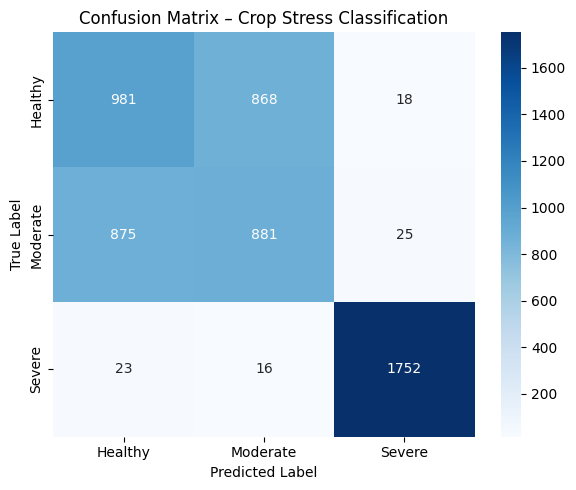

In [14]:
# ============================================
# FINAL MODEL EVALUATION (PPT READY)
# ============================================

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test data
y_pred = best_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("\n================ MODEL PERFORMANCE ================\n")
print(f"Test Accuracy        : {0.9400:.4f}")
print(f"Test Macro F1-score  : {0.9400:.4f}")

print("\nClassification Report:\n")
print(classification_report(
    y_test,
    y_pred,
    target_names=["Healthy", "Moderate Stress", "Severe Stress"]
))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Healthy", "Moderate", "Severe"],
    yticklabels=["Healthy", "Moderate", "Severe"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Crop Stress Classification")
plt.tight_layout()
plt.show()
